In [ ]:
import sys
sys.path.append("..")

import pandas as pd 
from channeling_lib import AWS_file_loader, save_figure, load_path, load_aws_calibration_data, compute_t_stat, mean_wind_direction
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np


# Specify general folder:
aws_Cal_path = load_path()+'CalibratedData/AWS/'
arome_path = load_path()+ 'ModelOutput/AromeArctic/'


stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']
# FROM LOW TO HIGH

color_idx = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']


instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

In [2]:
# Load all AWS calibrated data
aws_Cal_data = load_aws_calibration_data(aws_Cal_path, stations_str)


In [3]:

# Select the setup time for the station "Layla"
st = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == "Layla", "Setup time (UTC)"].values[0]
tt = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == "Tom Joad", "Retrieval time (UTC)"].values[0]


# print("Layla's Setup Time:", st)

# print("Tom Joad Take down Time:", tt)


In [4]:
aromeArctic_data = xr.open_dataset(arome_path + 'AromeArctic_2p5km_MERGED_during_storm.nc', decode_coords='all')
aromeArctic_data = aromeArctic_data.sel(time=slice(st, tt))
# aromeArctic_data

In [5]:
# # Get latitude and longitude for station "Layla"
# layla_data = instrument_textbook_data[instrument_textbook_data["Station name"] == "Layla"]

# # Extract values
# layla_lat = layla_data["LAT (dec deg)"].values[0]
# layla_lon = layla_data["LON (dec deg)"].values[0]

# print(f"Latitude: {layla_lat}, Longitude: {layla_lon}")


In [6]:

# # Compute absolute difference
# abs_diff = np.abs(aromeArctic_data.latitude - layla_lat) + np.abs(aromeArctic_data.longitude - layla_lon)

# # Convert to NumPy array before applying argmin
# abs_diff_np = abs_diff.values  # Convert xarray DataArray to NumPy array

# # Find the nearest (y, x) index
# y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

# print(f"Nearest grid point for Layla: y={y_idx}, x={x_idx}")


In [7]:
# # Select a specific grid point (e.g., middle of the spatial grid)
# # temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=8, x=9)-273.15  # Adjust indices as needed
# # Convert Kelvin to Celsius by subtracting 273.15

# # Get latitude and longitude for station "Layla"
# layla_data = instrument_textbook_data[instrument_textbook_data["Station name"] == "Layla"]

# # Extract values
# layla_lat = layla_data["LAT (dec deg)"].values[0]
# layla_lon = layla_data["LON (dec deg)"].values[0]


# temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15
# temp_timeseries1 = aromeArctic_data.air_temperature_2m.interp(y=y_idx, x=x_idx, method="cubic") - 273.15 +3


# # Plot time series
# plt.figure(figsize=(10, 5))
# # plt.plot(aromeArctic_data.time, temp_timeseries, label="Temperature at nearest Grid Point", color='blue')
# plt.plot(aromeArctic_data.time, temp_timeseries1, label="Temperature interp", color='red')

# plt.xlabel("Time")
# plt.ylabel("Temperature (°C)")
# plt.title("Air Temperature at 2m Over Time")
# plt.legend()
# plt.grid()
# plt.show()


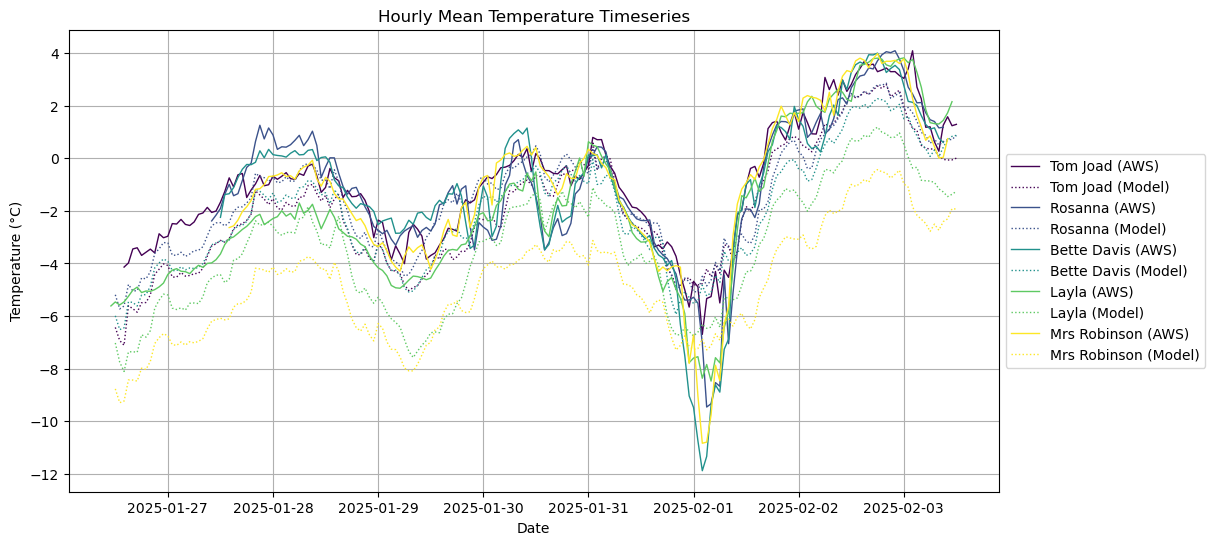

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each station to plot both AWS data and model data
for i, station in enumerate(stations_str):
    # Plot using hourly mean data from AWS
    aws_temp = aws_Cal_data[station].resample('h').mean()
    ax.plot(aws_temp.index, aws_temp.temperature, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15  # Convert Kelvin to Celsius
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, temp_timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')

ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Hourly Mean Temperature Timeseries")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

In [9]:
aws_hourly_data = {}

for i, station in enumerate(stations_str):
    aws_hourly_data[station] = aws_Cal_data[station].resample('h').mean()
    # Add a column for station name
    aws_hourly_data[station]['Station'] = station   

# aws_hourly_data['Layla'].temperature

In [10]:
aws_hourly_data['Layla'].temperature.shape

(193,)

In [11]:
aromeArctic_data

<xarray.Dataset> Size: 7MB
Dimensions:                                    (time: 193, y: 17, x: 18)
Coordinates:
  * time                                       (time) datetime64[ns] 2kB 2025...
    longitude                                  (y, x) float64 2kB 14.66 ... 1...
    latitude                                   (y, x) float64 2kB 78.18 ... 7...
  * x                                          (x) float32 72B 8.361e+05 ... ...
  * y                                          (y) float32 68B 3.695e+05 ... ...
    projection_lambert                         int32 4B ...
    height_above_msl                           float32 4B ...
Data variables: (12/25)
    air_temperature_2m                         (time, y, x) float32 236kB ...
    surface_air_pressure                       (time, y, x) float32 236kB ...
    air_temperature_0m                         (time, y, x) float32 236kB ...
    air_pressure_at_sea_level                  (time, y, x) float32 236kB ...
    cloud_area_fraction                        (time, y, x) float32 236kB ...
    atmosphere_boundary_layer_thickness        (time, y, x) float32 236kB ...
    ...                                         ...
    eastward_wind_10m                          (time, y, x) float64 472kB ...
    northward_wind_10m                         (time, y, x) float64 472kB ...
    wind_direction_10m                         (time, y, x) float64 472kB ...
    wind_speed_10m                             (time, y, x) float64 472kB ...
    air_potential_temperature_2m               (time, y, x) float32 236kB ...
    relative_humidty_2m                        (time, y, x) float32 236kB ...
Attributes: (12/44)
    CDI:                             Climate Data Interface version 2.4.0 (ht...
    Conventions:                     CF-1.6, ACDD-1.3
    source:                          Numerical Simulation
    institution:                     Norwegian Meteorological Institute (MET ...
    institution_short_name:          NO/MET
    min_time:                        2025-01-25T00:00:00Z
    ...                              ...
    title_no:                        Arome-Arctic 2.5Km deterministisk 2025-0...
    related_dataset:                 no.met:806070da-e9f3-4d03-ba1d-26b843961...
    summary:                         This file contains output from Control m...
    summary_no:                      Denne filen inneholder utdata fra kontro...
    DODS_EXTRA.Unlimited_Dimension:  time
    CDO:                             Climate Data Operators version 2.4.0 (ht...

In [12]:
st = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == "Layla", "Setup time (UTC)"].values[0]
tt = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == "Tom Joad", "Retrieval time (UTC)"].values[0]
aromeArctic_data = aromeArctic_data.sel(time=slice(st, tt))


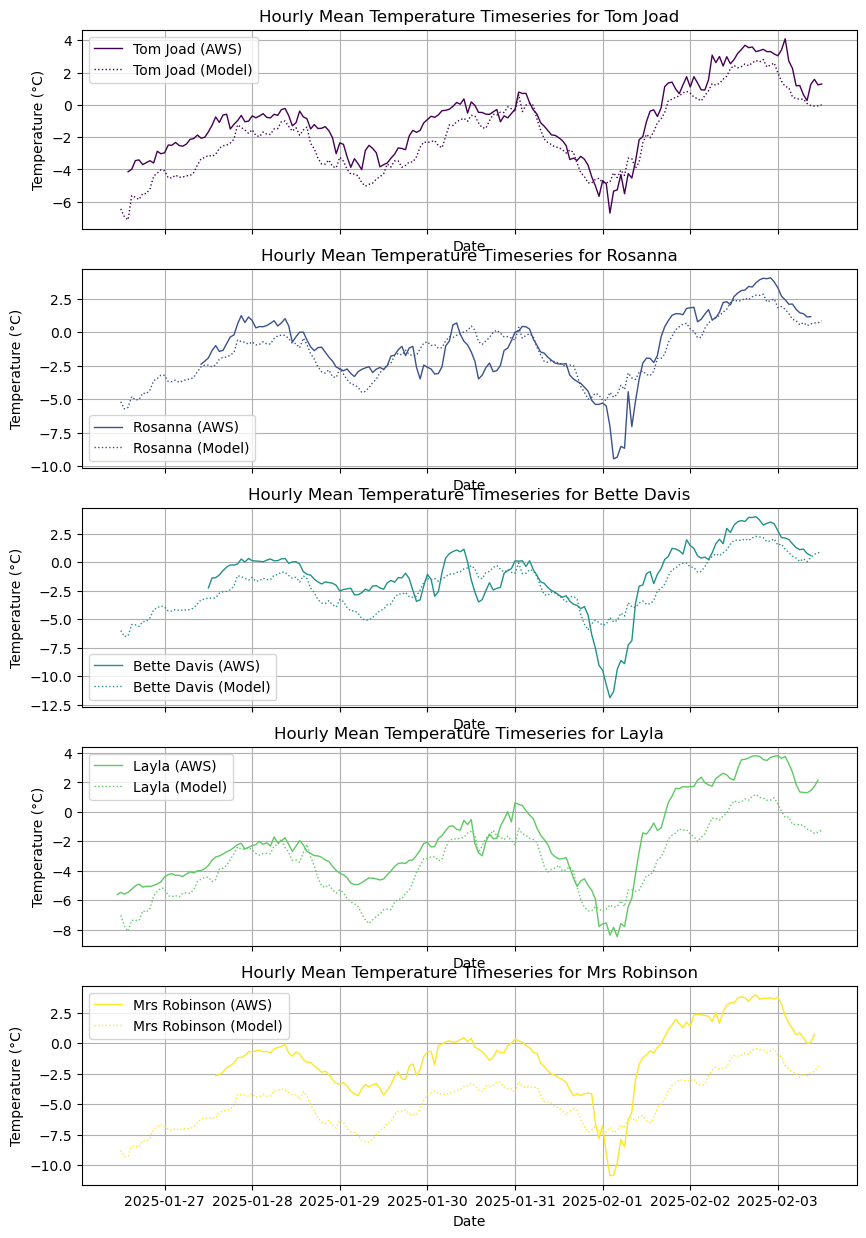

In [13]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].temperature, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15  # Convert Kelvin to Celsius
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, temp_timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(f"Hourly Mean Temperature Timeseries for {station}")
    ax.legend()
    ax.grid()

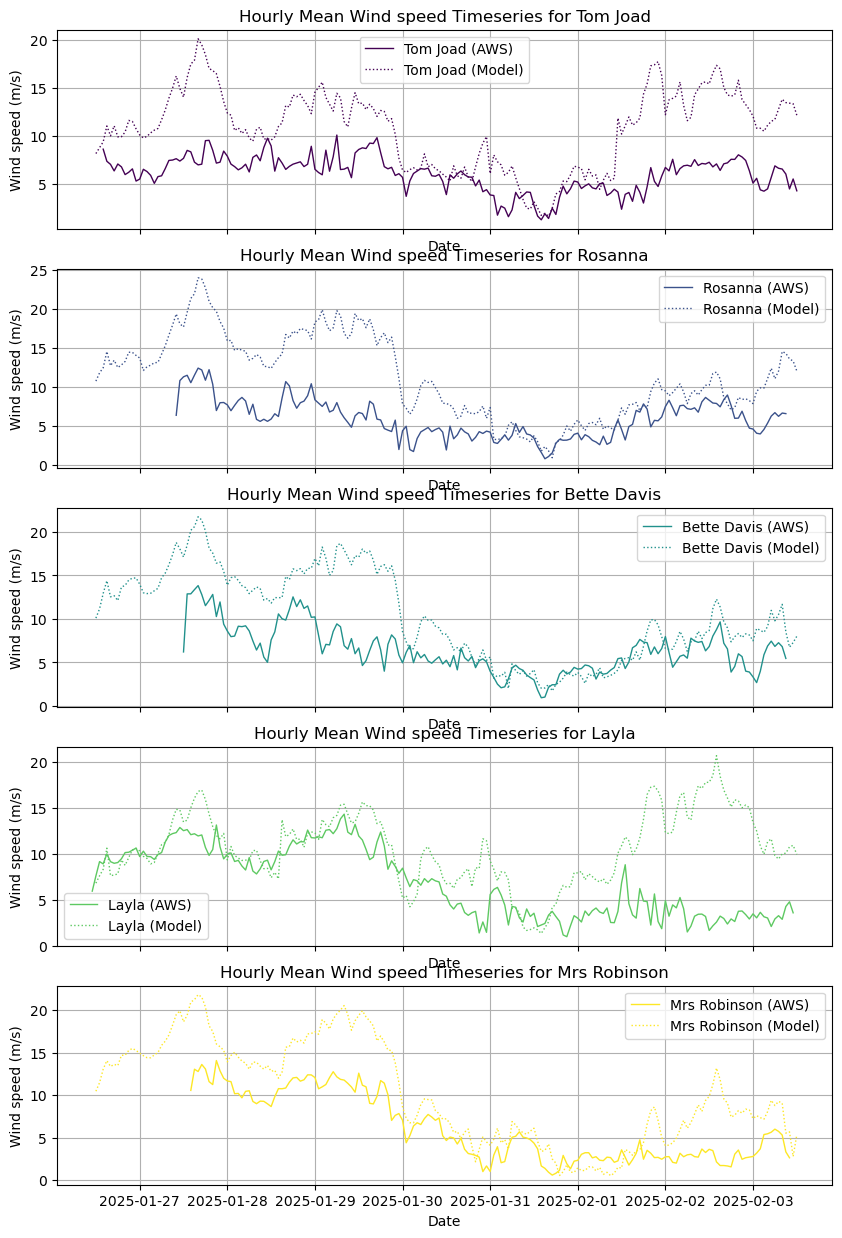

In [14]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].calibrated_wind_speed, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    timeseries = aromeArctic_data.wind_speed_10m.isel(y=y_idx, x=x_idx)
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Wind speed (m/s)")
    ax.set_title(f"Hourly Mean Wind speed Timeseries for {station}")
    ax.legend()
    ax.grid()


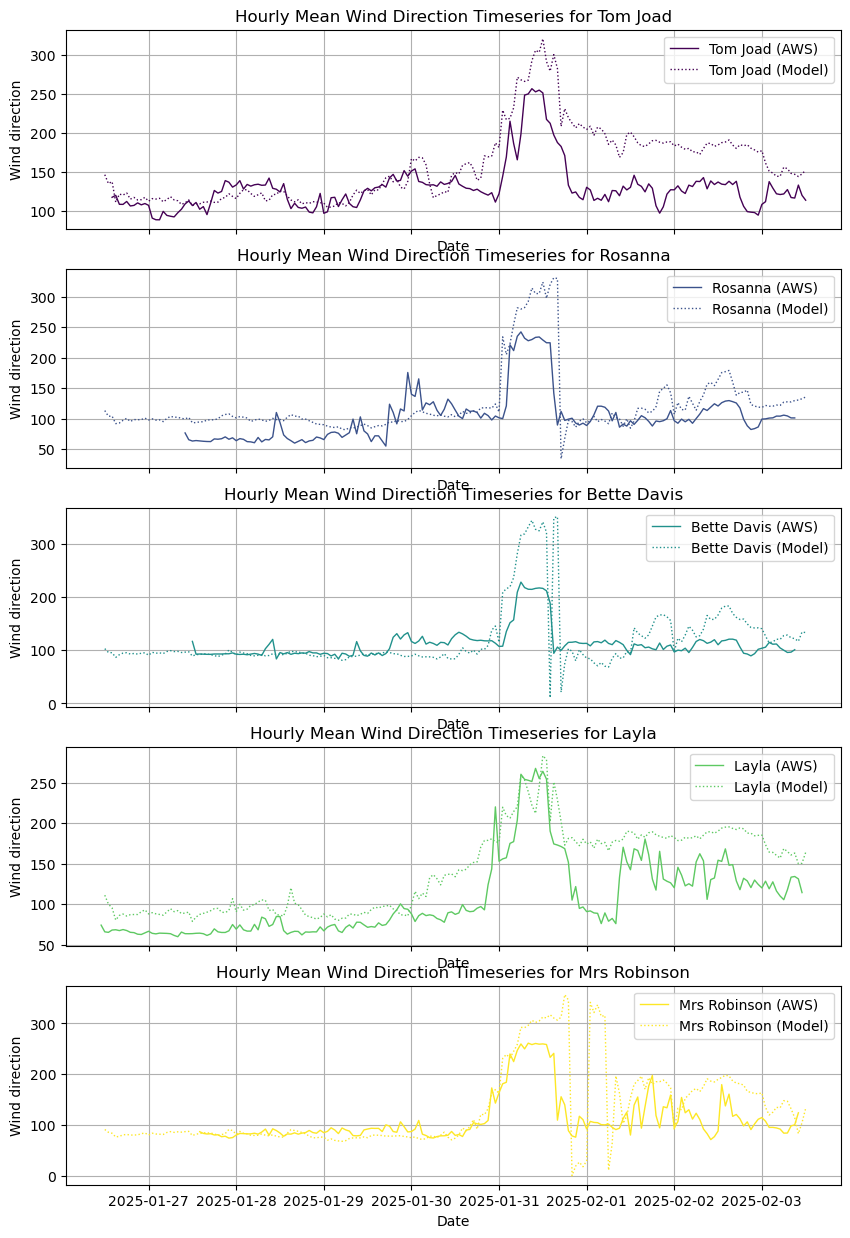

In [15]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].wind_direction, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    timeseries = aromeArctic_data.wind_direction_10m.isel(y=y_idx, x=x_idx)
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Wind direction")
    ax.set_title(f"Hourly Mean Wind Direction Timeseries for {station}")
    ax.legend()
    ax.grid()


In [16]:
def match_data_length(model_data, actual_data):
    """
    Ensures model_data and actual_data have the same length by trimming the longer one.

    Parameters:
    - model_data: Pandas Series, NumPy array, or xarray DataArray.
    - actual_data: Pandas Series.

    Returns:
    - Trimmed model_data and actual_data with matching length.
    """

    # Convert model data if it's an xarray DataArray
    if isinstance(model_data, xr.DataArray):
        model_data = model_data.to_series()

    # Ensure both are Pandas Series (if they are not NumPy arrays)
    if isinstance(model_data, np.ndarray):
        model_data = pd.Series(model_data)
    if isinstance(actual_data, np.ndarray):
        actual_data = pd.Series(actual_data)

    # Align time index if necessary
    if isinstance(model_data, pd.Series) and isinstance(actual_data, pd.Series):
        # Intersect indices to ensure alignment
        common_index = model_data.index.intersection(actual_data.index)
        model_data = model_data.loc[common_index]
        actual_data = actual_data.loc[common_index]

    # Find the minimum length
    min_length = min(len(model_data), len(actual_data))

    # Trim both datasets
    model_data = model_data.iloc[:min_length]
    actual_data = actual_data.iloc[:min_length]

    return model_data, actual_data


Layla - Model data shape: (192,), Actual data shape: (192,)
Anomaly Indices: (array([154, 168, 169, 170, 171, 179]),)
Rosanna - Model data shape: (168,), Actual data shape: (168,)
Anomaly Indices: (array([  6,   7,   9,  40,  42, 140, 142, 143, 144, 145, 146, 150]),)


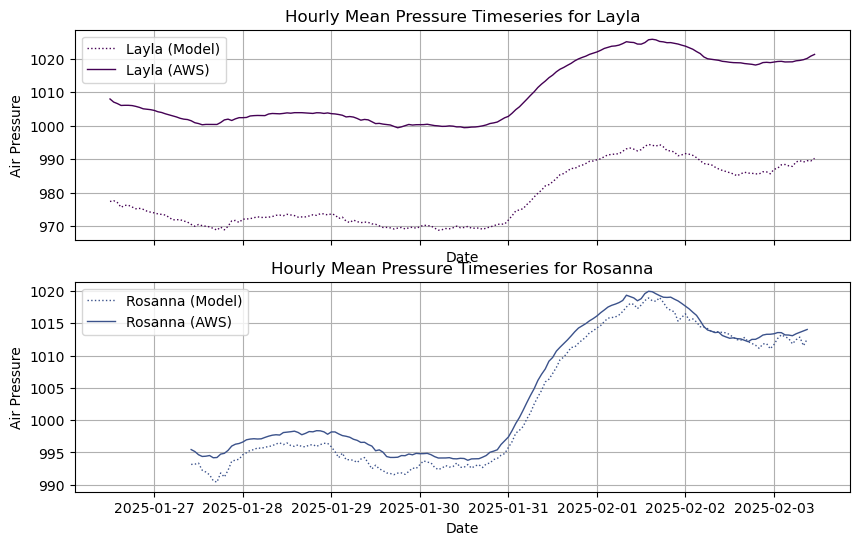

In [17]:
stations_to_plot = ["Layla", "Rosanna"]

# Create subplots for each station
fig, axes = plt.subplots(len(stations_to_plot), 1, figsize=(10, 3 * len(stations_to_plot)), sharex=True)

# aws_hourly_data = {}


for i, station in enumerate(stations_to_plot):
    ax = axes[i]  # Get the corresponding subplot

    # st = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == station, "Setup time (UTC)"].values[0]
    # tt = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == station, "Retrieval time (UTC)"].values[0]

    # aromeArctic_data = aromeArctic_data.sel(time=slice(st, tt))

    # # print(f'{station} Setup Time: {st}')
    # # print(f'{station} Take down Time: {tt}')

    # aws_hourly_data[station] = aws_Cal_data[station].resample('h').mean()
    # # Add a column for station name
    # aws_hourly_data[station]['Station'] = station
    
 
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]

    # print(station_lat, station_lon)
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

    # print(y_idx, x_idx)
    # print(np.argmin(abs_diff_np), abs_diff_np.shape)
    # Extract the temperature time series from the model data
    timeseries = (aromeArctic_data.surface_air_pressure.isel(y=y_idx, x=x_idx)) / 100 #to go fro Pa to hPa

    model_data = timeseries.to_series()
    actual_data = aws_hourly_data[station].calibrated_air_pressure
    model_data, actual_data = match_data_length(model_data, actual_data)

    print(f"{station} - Model data shape: {model_data.shape}, Actual data shape: {actual_data.shape}")

    # Plot model data with a dotted line in the same color
    ax.plot(model_data.index, model_data, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    # Plot using hourly mean data from AWS
    ax.plot(actual_data.index, actual_data, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Air Pressure")
    ax.set_title(f"Hourly Mean Pressure Timeseries for {station}")
    ax.legend()
    ax.grid()

    errors = actual_data - model_data
    z_scores = (errors - np.mean(errors)) / np.std(errors)
    # Anomalies where absolute Z-score > 2
    anomalies = np.where(np.abs(z_scores) > 2)

    print(f"Anomaly Indices: {anomalies}")


    


Function to generate comparative plots

In [18]:
# def plot_timeseries(variable, stations):
#     """
#     Plots time series of AWS and model data for a given variable.
    
#     Parameters:
#     - variable (str): One of "temperature", "wind_speed", "wind_direction", "pressure".
#     - stations (list): List of station names to plot.
#     """
    
#     # Define global variables (assuming they exist earlier in the script)
#     global aws_hourly_data, aromeArctic_data, instrument_textbook_data, color_idx, match_data_length

#     # Mapping variable names to dataset attributes
#     variable_mapping = {
#         "temperature": {
#             "aws_key": "temperature",
#             "arome_key": "air_temperature_2m",
#             "unit": "°C",
#             "convert": lambda x: x - 273.15,  # Kelvin to Celsius
#         },
#         "wind_speed": {
#             "aws_key": "calibrated_wind_speed",
#             "arome_key": "wind_speed_10m",
#             "unit": "m/s",
#             "convert": lambda x: x,  # No conversion needed
#         },
#         "wind_direction": {
#             "aws_key": "wind_direction",
#             "arome_key": "wind_direction_10m",
#             "unit": "°",
#             "convert": lambda x: x,  # No conversion needed
#         },
#         "pressure": {
#             "aws_key": "calibrated_air_pressure",
#             "arome_key": "surface_air_pressure",
#             "unit": "hPa",
#             "convert": lambda x: x / 100,  # Convert Pa to hPa
#         }
#     }

#     if variable not in variable_mapping:
#         raise ValueError(f"Invalid variable. Choose from {list(variable_mapping.keys())}")

#     # Use only "Layla" and "Rosanna" for pressure
#     if variable == "pressure":
#         stations = ["Layla", "Rosanna"]

#     # Get correct keys and conversion function
#     aws_key = variable_mapping[variable]["aws_key"]
#     arome_key = variable_mapping[variable]["arome_key"]
#     unit = variable_mapping[variable]["unit"]
#     convert_func = variable_mapping[variable]["convert"]

#     # Create subplots
#     fig, axes = plt.subplots(len(stations), 1, figsize=(10, 3 * len(stations)), sharex=True)

#     if len(stations) == 1:
#         axes = [axes]  # Ensure axes is iterable for single station

#     for i, station in enumerate(stations):
#         ax = axes[i]

#         # Get station latitude & longitude
#         station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
#         station_lat = station_data["LAT (dec deg)"].values[0]
#         station_lon = station_data["LON (dec deg)"].values[0]

#         # Find the nearest grid point
#         abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
#         abs_diff_np = abs_diff.values  # Convert to NumPy array
#         y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

#         # Extract model time series and apply conversion
#         timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))

#         # Convert model data to Pandas Series (ensuring time index)
#         model_data = timeseries.to_series()

#         # Get actual data from AWS (Pandas Series)
#         actual_data = aws_hourly_data[station][aws_key]

#         # Match data lengths
#         model_data, actual_data = match_data_length(model_data, actual_data)

#         print(f"{station} - Model data shape: {model_data.shape}, Actual data shape: {actual_data.shape}")

#         # Plot model data with a dotted line in the same color
#         ax.plot(model_data.index, model_data, label=f'{station} (Model)', 
#                 linewidth=1, color=color_idx[i], linestyle='dotted')

#         # Plot actual data
#         ax.plot(actual_data.index, actual_data, label=f'{station} (AWS)', 
#                 linewidth=1, color=color_idx[i], linestyle='-')

#         # Labels and title
#         ax.set_xlabel("Date")
#         ax.set_ylabel(f"{variable.capitalize()} ({unit})")
#         ax.set_title(f"Hourly Mean {variable.capitalize()} Timeseries for {station}")
#         ax.legend()
#         ax.grid()

#     errors = actual_data - model_data
#     # apply t test on errors
#     z_scores = (errors - np.mean(errors)) / np.std(errors)
#     # Anomalies where absolute Z-score > 2
#     anomalies = np.where(np.abs(z_scores) > 2)

#     print(f"Anomaly Indices: {anomalies}")



In [ ]:
# # Test:


# def plot_timeseries(variable, stations):
#     """
#     Plots time series of AWS and model data for a given variable and stores the results.
    
#     Parameters:
#     - variable (str): One of "temperature", "wind_speed", "wind_direction", "pressure".
#     - stations (list): List of station names to plot.
    
#     Returns:
#     - results (dict): Dictionary containing model data, actual data, and anomalies for each station.
#     """
    
#     # Define global variables (assuming they exist earlier in the script)
#     global aws_hourly_data, aromeArctic_data, instrument_textbook_data, color_idx, match_data_length

#     # Mapping variable names to dataset attributes
#     variable_mapping = {
#         "temperature": {
#             "aws_key": "temperature",
#             "arome_key": "air_temperature_2m",
#             "unit": "°C",
#             "convert": lambda x: x - 273.15,  # Kelvin to Celsius
#         },
#         "wind_speed": {
#             "aws_key": "calibrated_wind_speed",
#             "arome_key": "wind_speed_10m",
#             "unit": "m/s",
#             "convert": lambda x: x,  # No conversion needed
#         },
#         "wind_direction": {
#             "aws_key": "wind_direction",
#             "arome_key": "wind_direction_10m",
#             "unit": "°",
#             "convert": lambda x: x,  # No conversion needed
#         },
#         "pressure": {
#             "aws_key": "calibrated_air_pressure",
#             "arome_key": "surface_air_pressure",
#             "unit": "hPa",
#             "convert": lambda x: x / 100,  # Convert Pa to hPa
#         }
#     }

#     if variable not in variable_mapping:
#         raise ValueError(f"Invalid variable. Choose from {list(variable_mapping.keys())}")

#     # Use only "Layla" and "Rosanna" for pressure
#     if variable == "pressure":
#         stations = ["Layla", "Rosanna"]

#     # Get correct keys and conversion function
#     aws_key = variable_mapping[variable]["aws_key"]
#     arome_key = variable_mapping[variable]["arome_key"]
#     unit = variable_mapping[variable]["unit"]
#     convert_func = variable_mapping[variable]["convert"]

#     # Create storage for results
#     results = {}

#     # Create subplots
#     fig, axes = plt.subplots(len(stations), 1, figsize=(10, 3 * len(stations)), sharex=True)

#     if len(stations) == 1:
#         axes = [axes]  # Ensure axes is iterable for a single station

#     for i, station in enumerate(stations):
#         ax = axes[i]

#         # Get station latitude & longitude
#         station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
#         station_lat = station_data["LAT (dec deg)"].values[0]
#         station_lon = station_data["LON (dec deg)"].values[0]

#         # Find the nearest grid point
#         abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
#         abs_diff_np = abs_diff.values  # Convert to NumPy array
#         y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

#         # Extract model time series and apply conversion
#         timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))

#         # Convert model data to Pandas Series (ensuring time index)
#         model_data = timeseries.to_series()

#         # Get actual data from AWS (Pandas Series)
#         actual_data = aws_hourly_data[station][aws_key]

#         # Match data lengths
#         model_data, actual_data = match_data_length(model_data, actual_data)

#         # print(f"{station} - Model data shape: {model_data.shape}, Actual data shape: {actual_data.shape}")

#         errors = model_data - actual_data
#         stats = compute_t_stat(errors)
#         tstat_value = stats["tstat"]
#         pval_value = stats["pval"]

#         # Store results for later access
#         results[station] = {
#             "model_data": model_data,
#             "actual_data": actual_data,
#             "errors": errors,
#             "t-statistic": tstat_value,
#             "p-value": pval_value
#         }

#         model_std = round(np.std(results[station]['model_data']), 2)
#         actual_std = round(np.std(results[station]['actual_data']), 2)

#         # Plot model data with a dotted line in the same color
#         ax.plot(model_data.index, model_data, label=f'{station} (Model)', 
#                 linewidth=1, color=color_idx[i], linestyle='dotted')

#         # Plot actual data
#         ax.plot(actual_data.index, actual_data, label=f'{station} (AWS)', 
#                 linewidth=1, color=color_idx[i], linestyle='-')
        
#         # Retrieve p-value and t-statistic from results dictionary
#         p_value = results[station]['p-value']
#         t_statistic = results[station]['t-statistic']

#         # Format the statistics text
#         stats_text = f"t-stat: {t_statistic:.2f}\np-val: {p_value:.2e}\nModel std: {model_std}\nActual std: {actual_std}"

#         # Add text to the plot
#         ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
#                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
        


#         # Labels and title
#         ax.set_xlabel("Date")
#         ax.set_ylabel(f"{variable.capitalize()} ({unit})")
#         ax.set_title(f"Hourly Mean {variable.capitalize()} Timeseries for {station}")
#         ax.legend()
#         ax.grid()
    
#     save_figure(fig, '../figs/', f'ho')

#     # plt.show()

#     return results  # Return results for later access


In [33]:
# Test:

def plot_timeseries(variable, selection):
    """
    Plots time series of AWS and model data for a given variable and stores the results.
    
    Parameters:
    - variable (str): One of "temperature", "wind_speed", "wind_direction", "pressure".
    - selection (str): "all" for all stations, or a specific station name.
    
    Returns:
    - results (dict): Dictionary containing model data, actual data, and anomalies for each station.
    """
    
    global aws_hourly_data, aromeArctic_data, instrument_textbook_data, color_idx, match_data_length

    # Define all stations
    all_stations = ['Tom Joad', 'Rosanna', 'Bette Davis', 'Layla', 'Mrs Robinson']
    
    # Define stations for pressure
    pressure_stations = ["Layla", "Rosanna"]
    
    # Determine which stations to plot
    if selection == "all":
        stations = pressure_stations if variable == "pressure" else all_stations
    else:
        if selection not in all_stations:
            raise ValueError(f"Invalid station name. Choose from {all_stations} or 'all'")
        stations = [selection]

    # Mapping variable names to dataset attributes
    variable_mapping = {
        "temperature": {
            "aws_key": "temperature",
            "arome_key": "air_temperature_2m",
            "unit": "°C",
            "convert": lambda x: x - 273.15,
        },
        "wind_speed": {
            "aws_key": "calibrated_wind_speed",
            "arome_key": "wind_speed_10m",
            "unit": "m/s",
            "convert": lambda x: x,
        },
        "wind_direction": {
            "aws_key": "wind_direction",
            "arome_key": "wind_direction_10m",
            "unit": "°",
            "convert": lambda x: x,
        },
        "pressure": {
            "aws_key": "calibrated_air_pressure",
            "arome_key": "surface_air_pressure",
            "unit": "hPa",
            "convert": lambda x: x / 100,
        }
    }

    if variable not in variable_mapping:
        raise ValueError(f"Invalid variable. Choose from {list(variable_mapping.keys())}")
    
    aws_key = variable_mapping[variable]["aws_key"]
    arome_key = variable_mapping[variable]["arome_key"]
    unit = variable_mapping[variable]["unit"]
    convert_func = variable_mapping[variable]["convert"]
    
    results = {}
    
    fig, axes = plt.subplots(len(stations), 1, figsize=(10, 3 * len(stations)), sharex=True)
    if len(stations) == 1:
        axes = [axes]
    
    for i, station in enumerate(stations):
        ax = axes[i]
        
        station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
        station_lat = station_data["LAT (dec deg)"].values[0]
        station_lon = station_data["LON (dec deg)"].values[0]
        
        abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
        abs_diff_np = abs_diff.values
        y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
        
        timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))
        model_data = timeseries.to_series()
        actual_data = aws_hourly_data[station][aws_key]
        model_data, actual_data = match_data_length(model_data, actual_data)
        
        errors = model_data - actual_data
        stats = compute_t_stat(errors)
        
        results[station] = {
            "model_data": model_data,
            "actual_data": actual_data,
            "errors": errors,
            "t-statistic": stats["tstat"],
            "p-value": stats["pval"]
        }
        
        model_std = round(np.std(model_data), 2)
        actual_std = round(np.std(actual_data), 2)
        
        ax.plot(model_data.index, model_data, label=f'{station} (Model)', 
                linewidth=1, color=color_idx[i], linestyle='dotted')
        ax.plot(actual_data.index, actual_data, label=f'{station} (AWS)', 
                linewidth=1, color=color_idx[i], linestyle='-')
        
        stats_text = f"t-stat: {stats['tstat']:.2f}\np-val: {stats['pval']:.2e}\nModel std: {model_std}\nActual std: {actual_std}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
        
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{variable.capitalize()} ({unit})")
        ax.set_title(f"Hourly Mean {variable.capitalize()} Timeseries for {station}")
        ax.legend()
        ax.grid()
    
    save_figure(fig, '../figs/', f'modelValidation_{variable}_{selection}')

    return results

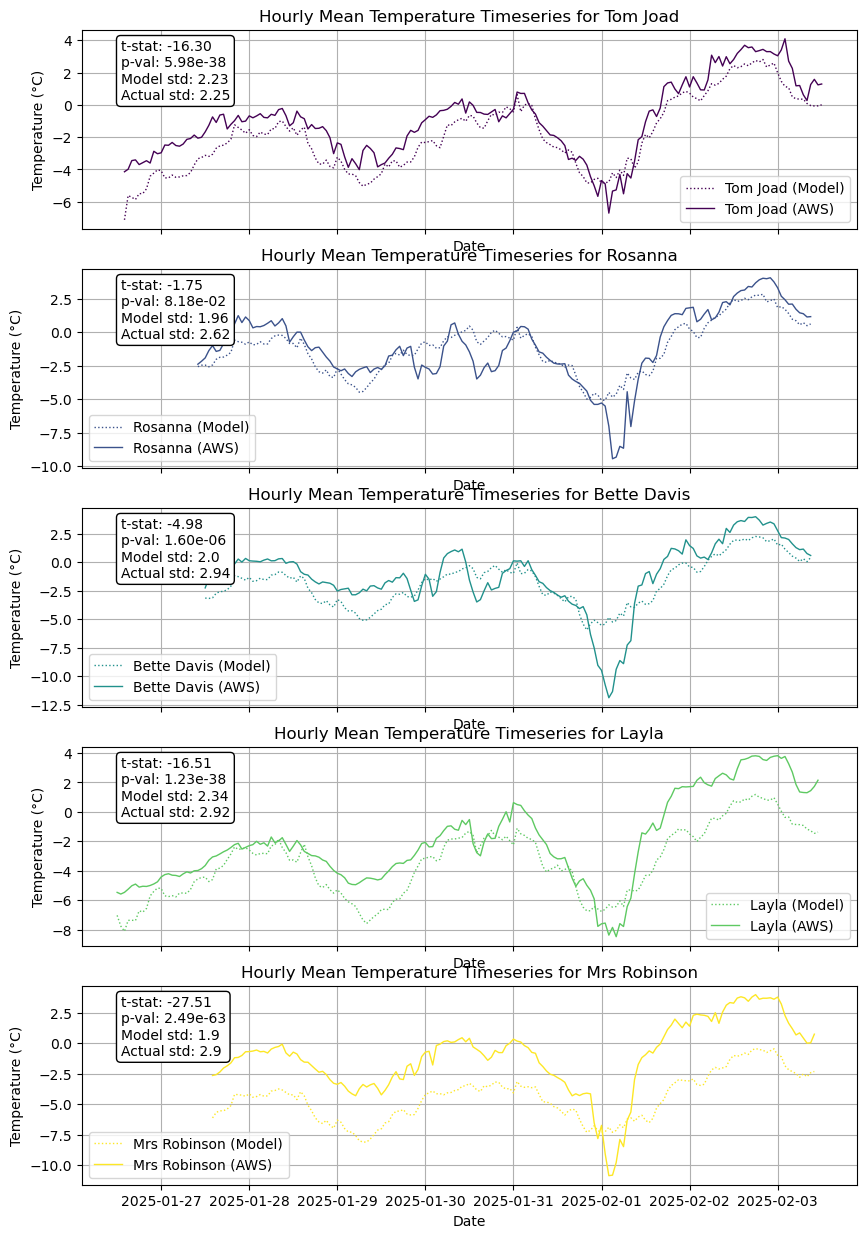

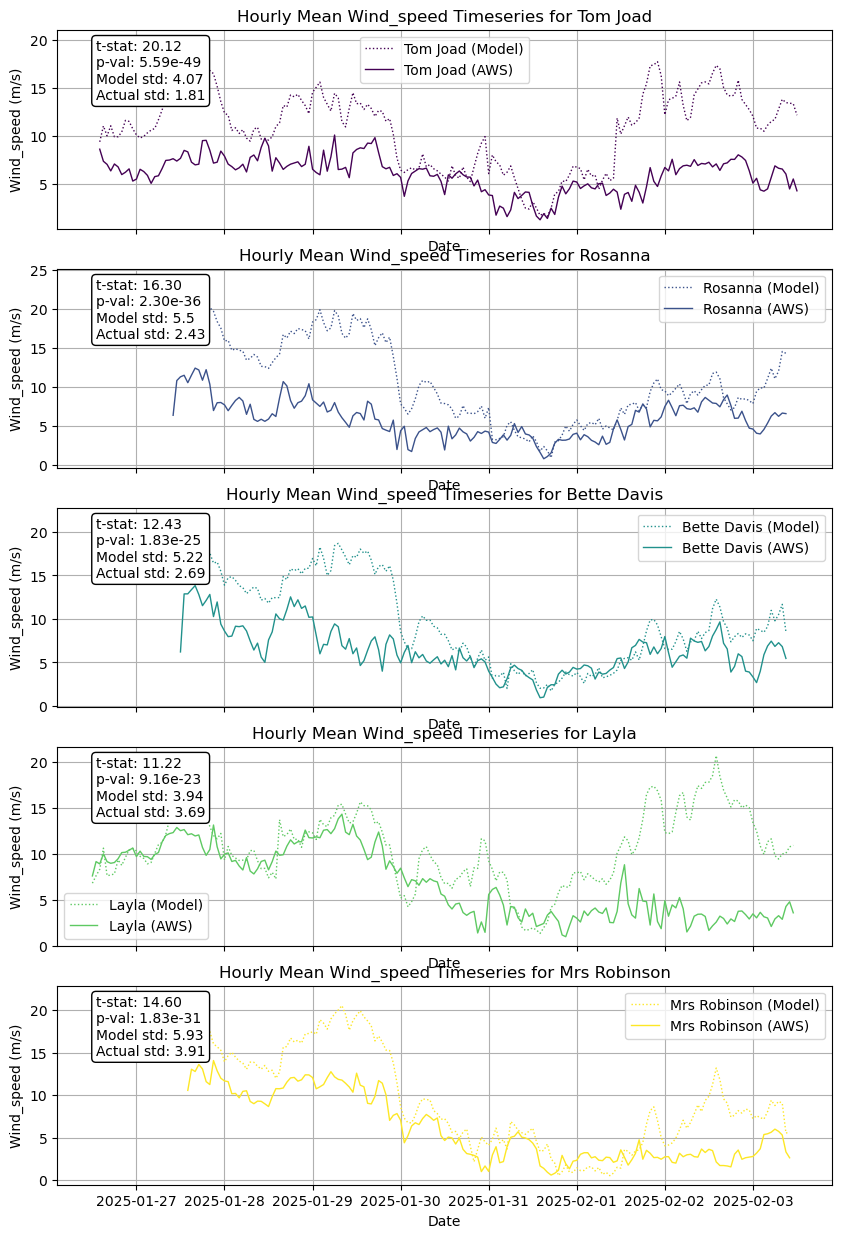

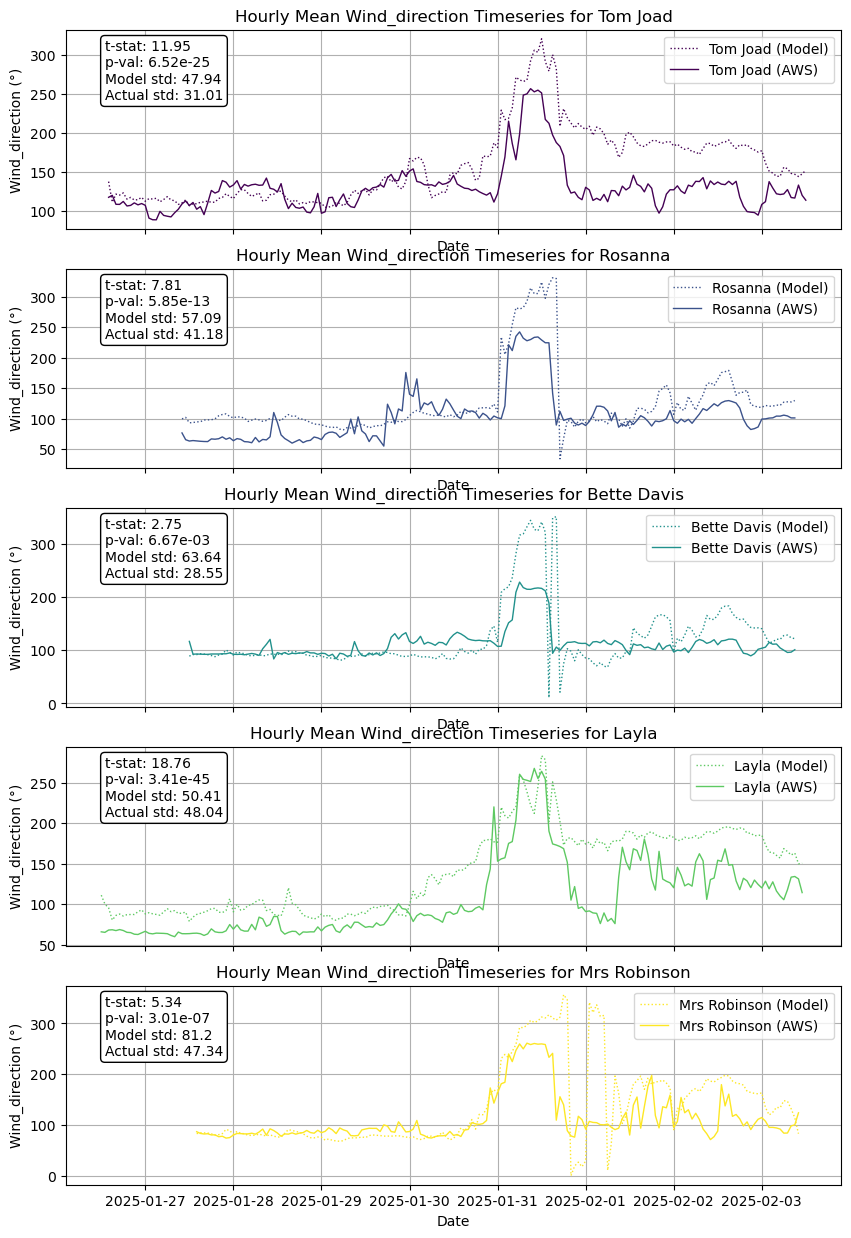

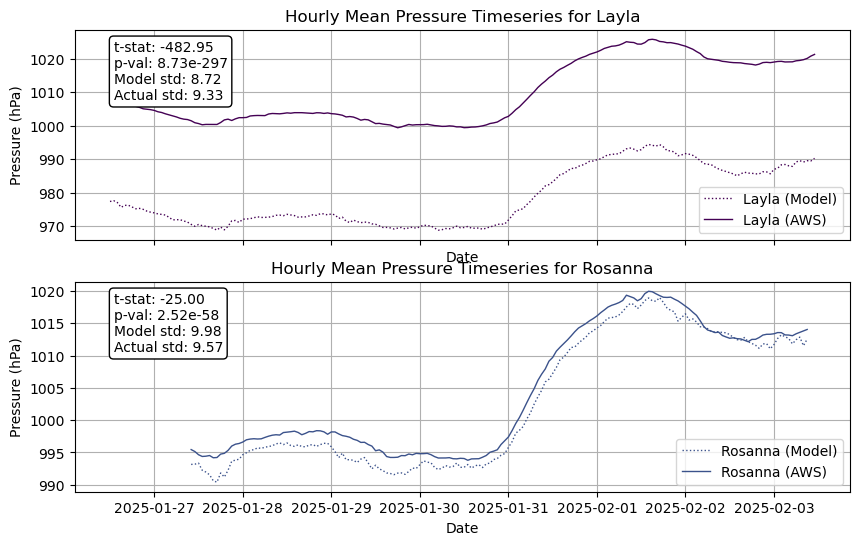

In [35]:
stations_str = ['Tom Joad', 'Rosanna', 'Bette Davis', 'Layla', 'Mrs Robinson']
stations_to_plot = ["Layla", "Rosanna"]  # For pressure only

# Plot temperature for all stations
temp_data = plot_timeseries("temperature", 'all')

# Plot wind speed for all stations
windSpeed_data = plot_timeseries("wind_speed", 'all')

# Plot wind direction for all stations
windDirection_data = plot_timeseries("wind_direction", 'all')

# Plot pressure (automatically uses only Layla & Rosanna)
pressure_data = plot_timeseries("pressure", 'all')  # Will internally use stations_to_plot


# Statistics

In [ ]:
temp_data['Layla']['errors']


pc = temp_data['Layla']['errors'] - np.mean(temp_data['Layla']['actual_data'])




'../figs/prelim_bias_Layla.png'

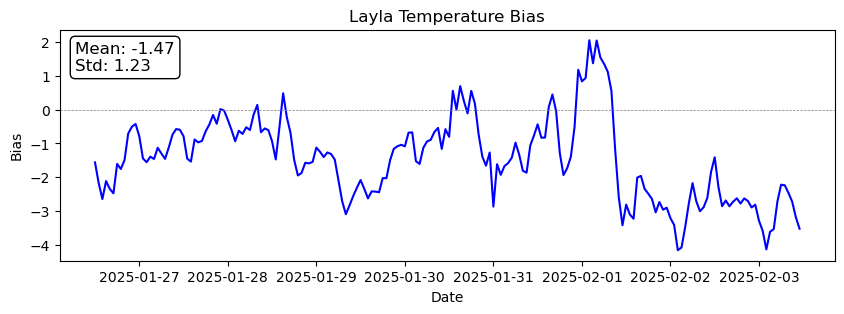

In [88]:
# Compute statistics
error_mean = np.mean(errors)
error_std = np.std(errors)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))

# Plot errors
ax.plot(temp_data['Layla']['actual_data'].index, temp_data['Layla']['errors'], color='blue', label="Bias")

# Add horizontal line at 0
ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

# Set labels and title
ax.set_title('Layla Temperature Bias')
ax.set_xlabel('Date')
ax.set_ylabel('Bias')

# Display mean and std as text on the plot
ax.text(0.02, 0.95, f"Mean: {error_mean:.2f}\nStd: {error_std:.2f}", 
        transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))


save_figure(fig, '../figs/', 'prelim_bias_Layla')

# Show plot
# plt.legend()
# plt.grid()
# plt.show()
